Author: Riddhima Puri

22/07/2021

Simulations with petitRadTrans python package with Venot et al. 2020 atmospheric profiles.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from petitRADTRANS import Radtrans #All units in cgs except pressure which is in bar
from petitRADTRANS import nat_cst as nc
# Some styling changes
from pylab import rcParams
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.labelsize'] = 'x-large'
rcParams['axes.titlesize'] = 'xx-large'
rcParams['axes.titleweight'] = 'bold'
rcParams['figure.titleweight'] = 'bold'
rcParams['figure.titlesize'] = 'xx-large'
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'
rcParams['legend.fontsize'] = 'x-large'


In [22]:
def read_venotetal(fname):

    #Extracting Venot et al data

    data = open(fname, 'r' )
    data=data.read().splitlines()
    
    #Species provided
    species=data[0].split()
    mass=data[1].split()
    
    #Atmospheric Profile
    prof=np.zeros([len(data), len(data[2].split())])
    for i in range(2,len(data)):
        prof[i-2,:]=data[i].split() #Altitude[km], pressure[mbar], mixing ratio of species
    prof[:,1]=prof[:,1]*1e-3 #Pressure [bar]
    return species, mass, prof

In [23]:
#Updated chemical scheme
species1, mass1, prof1 = read_venotetal('HD_209458b/Venot et al Profiles/fractions_molaires_HD209458b_O08.633_C08.390_N07.860Kzz_variable_NewMeth_1d8s_HV.dat')

# fractions_molaires_HD209458b_O08.633_C08.867_N07.860Kzz_variable_NewMeth_1d8s_long.dat = C/O ratio 3 times solar
    
lenprof=len(prof1) #Number of layers
prof=prof1[0:lenprof-2,:] #Cleaning data

#Index of main species in HD209458b according to Venot et al.
ind_m = [species1.index('CO2'), species1.index('NH3'), species1.index('HCN'), species1.index('CH4'),
         species1.index('CO'), species1.index('H2O'), species1.index('H2')] 

species=[]
for i in range(len(ind_m)):
    species.append(species1[ind_m[i]])


In [24]:
mass1[44]

'32.000'

In [25]:
species1.index('O2')

44

Loading PT profile used in the paper (taken from Moses et al)

In [26]:
fname='HD_209458b/Venot et al Profiles/profil_HD209458b.dat'
data=open(fname, 'r' )
data=data.read().splitlines()

In [27]:
#Pressure Temp Profile
P=np.zeros(len(data))
T=np.zeros(len(data))

for i in range(len(data)):
    temp=[]
    temp=data[i].split()
    P[i]=float(temp[1])*1e-3 #Pressure in mbar originally
    T[i]=float(temp[2])

In [28]:
Tnew=np.zeros(len(prof[:,1])) #downsampled T to match the dimensions of abundance profiles
for i in range(len(prof)):
    idx=(np.abs(P-prof[i,1])).argmin()
    Tnew[i]=T[idx]

Text(0, 0.5, 'Pressure (bar)')

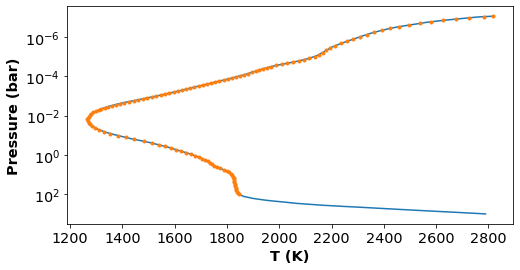

In [29]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(T,P)
ax.plot(Tnew, prof[:,1], '.')
plt.gca().invert_yaxis()
plt.yscale("log")
plt.xlabel("T (K)")
plt.ylabel("Pressure (bar)")

In [30]:
#Input Parameters of pRT

# R_pl = 192954/2 * 100000 #cm #1.838*nc.r_jup_mean #Planetary Radius
R_pl = 1.359*nc.r_jup_mean
gravity = 1.49*100 #cm/s2 #Gravity at given pressure, P0
P0 = 0.01 #bar ?
    
#Atmospheric Mean Molecular Weight
MMW = 2.27 * np.ones_like(Tnew) 

#Conversion from VMR to mass fraction = (mass of molecule/MMW)*VMR
mass_fractions = {}

for i in range(len(ind_m)):
    mass_fractions[species[i]]=(float(mass1[ind_m[i]])/MMW)*prof[:,(ind_m[i]+2)][::-1]

In [13]:
def pRT(specadd, abun, mass, Pprof, Tprof, spec, mass_frac, MMW):
    '''
        specadd (str) = list of species to be added apart from the ones provided by Venot et al
        abun (float) = list of abundances of the species in volume mixing ratio in the same order as spec
        mass (float) = mass of the species
        Pprof = (increasing order) Pressure profile
    '''
    
    temperature = Tprof
#     species_new=species
#     mass_fractions_new=mass_fractions
    
    if specadd:
        for i in range(len(specadd)):
            spec.append(specadd[i])
            mass_frac[specadd[i]]= (mass[i])/MMW * abun[i] * np.ones_like(temperature) #Na mass = 22.98u
            
    
    atmosphere = Radtrans(line_species = spec, rayleigh_species = ['H2', 'H2O'], 
                      continuum_opacities = ['H2-H2', 'H2O-H2O'], wlen_bords_micron = [0.3, 15])
    
    atmosphere.setup_opa_structure(Pprof)
        
    atmosphere.calc_transm(temperature, mass_frac, gravity, MMW, R_pl=R_pl, P0_bar=P0)
    
    return atmosphere

Load ESPRESSO data from Santos et al. 2020

In [14]:
fname='out_transmission_4bin.txt'
data_es = open(fname, 'r' )
data_es=data_es.read().splitlines()

wavld_es=np.zeros(len(data_es)) #Wavelength down
wavlu_es=np.zeros(len(data_es)) #Wavelength up
Rp_es=np.zeros(len(data_es)) #Rp/R*
Rp_eru_es=np.zeros(len(data_es)) #Rp/R* error up
Rp_erd_es=np.zeros(len(data_es)) #Rp/R* error down

for i in range(1,len(data_es)):
    temp=[]
    temp=data_es[i].split(';')
    wavld_es[i]=float(temp[1])
    wavlu_es[i]=float(temp[2])
    Rp_es[i]=float(temp[3])
    Rp_eru_es[i]=float(temp[4])
    Rp_erd_es[i]=float(temp[5])
    
    
#Wavelength error bars
diff=np.zeros(len(wavlu_es))
for i in range(len(wavlu_es)):
    diff[i]=(wavlu_es[i]-wavld_es[i])/2

#Updated Error to get Transmission Spectra (square of Rp/R*)
test1=[]
test1=Rp_es+Rp_eru_es
Rp_eru_sq=test1**2-Rp_es**2

test2=[]
test2=Rp_es-Rp_erd_es
Rp_erd_sq= Rp_es**2-test2**2


In [15]:
del mass_fractions['Na']
del mass_fractions['TiO']

species.remove('Na')
species.remove('TiO')

KeyError: 'Na'

In [16]:
#Na = 1ppm
atm1=pRT(['Na'],[1e-6], [22.98], prof[:,1][::-1], Tnew, species, mass_fractions, MMW)


  Read CIA opacities for H2-H2...
 Done.



In [17]:
del mass_fractions['Na']
species.remove('Na')

In [31]:
#Na = 0.1ppm
atm2=pRT(['Na'],[1e-7], [22.98], prof[:,1][::-1], Tnew, species, mass_fractions, MMW)


  Read CIA opacities for H2-H2...
 Done.



In [32]:
del mass_fractions['Na']
species.remove('Na')

In [22]:
#Na = 10ppm
atm3=pRT(['Na'],[10e-6], [22.98], prof[:,1][::-1], Tnew, species, mass_fractions, MMW)


  Read CIA opacities for H2-H2...
 Done.



In [23]:
del mass_fractions['Na']
species.remove('Na')

In [ ]:
#Na = 30ppm
atm6=pRT(['Na'],[30e-6], [22.98], prof[:,1][::-1], Tnew, species, mass_fractions, MMW)

del mass_fractions['Na']
species.remove('Na')

In [18]:
diff_rp=np.zeros_like(atm1.freq[100:1000])
for i in range(len(atm1.transm_rad[100:1000])):
    idx=(np.abs(wavlu_es[2:len(Rp_es)]-(nc.c/atm1.freq[100+i])*1e7)).argmin()
    diff_rp[i]=Rp_es[idx]**2-(atm1.transm_rad[100+i]/nc.r_jup_mean)*1e-2

In [28]:
np.sqrt(abs(np.average(diff_rp))) #Take the difference according to wavelength 

0.03882930905439011

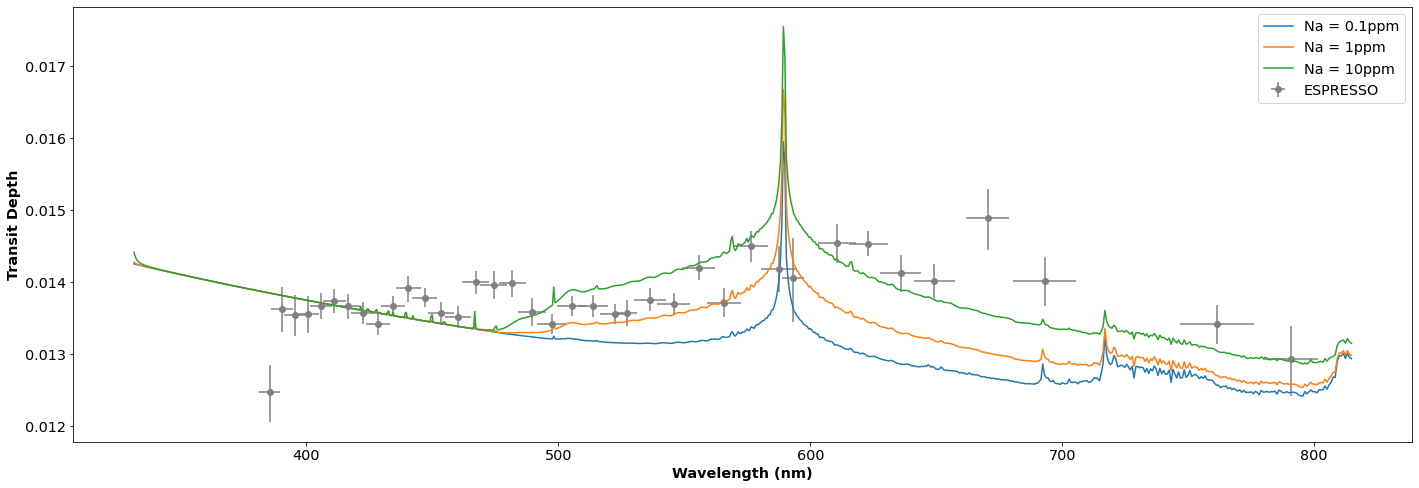

In [108]:
fig, ax = plt.subplots(1,1,figsize=(24,8))

#Plot Espresso Data
ax.errorbar(wavlu_es[2:len(Rp_es)], (Rp_es[2:len(Rp_es)] - 0.0034)**2, 
             yerr=[Rp_eru_sq[2:len(Rp_es)], Rp_erd_sq[2:len(Rp_es)]], 
            xerr=diff[2:len(Rp_es)], marker='o', linestyle='', color='grey', label='ESPRESSO')


ax.plot((nc.c/atm2.freq[100:1000])*1e7, (atm2.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='Na = 0.1ppm')
ax.plot((nc.c/atm1.freq[100:1000])*1e7, (atm1.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='Na = 1ppm')
ax.plot((nc.c/atm3.freq[100:1000])*1e7, (atm3.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='Na = 10ppm')
# ax.plot((nc.c/atm6.freq[100:1000])*1e7, (atm6.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='Na = 30ppm')

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transit Depth")

ax.legend()

# plt.savefig("NaTest3_pRT.jpg", dpi=150)

plt.show()

In [78]:
species

['CO2', 'NH3', 'HCN', 'CH4', 'CO', 'H2O', 'H2']

In [77]:
# #TiO = 1ppb
# atm4=pRT(['TiO'],[1e-9], [63.86], prof[:,1][::-1], Tnew, species, mass_fractions, MMW)

# del mass_fractions['TiO']
species.remove('TiO')

In [79]:
# del mass_fractions['Na']
# species.remove('Na')

#TiO = 1ppb
atm4=pRT(['TiO'],[1e-9], [63.86], prof[:,1][::-1], Tnew, species, mass_fractions, MMW)

del mass_fractions['TiO']
species.remove('TiO')


#TiO = 0.5ppb
atm5=pRT(['TiO'],[5e-10], [63.86], prof[:,1][::-1], Tnew, species, mass_fractions, MMW)

del mass_fractions['TiO']
species.remove('TiO')

#TiO = 0.25ppb
atm6=pRT(['TiO'],[2.5e-10], [63.86], prof[:,1][::-1], Tnew, species, mass_fractions, MMW)

del mass_fractions['TiO']
species.remove('TiO')

#TiO = 0.1ppb
atm_1=pRT(['TiO'],[1e-10], [63.86], prof[:,1][::-1], Tnew, species, mass_fractions, MMW)

del mass_fractions['TiO']
species.remove('TiO')


  Read CIA opacities for H2-H2...
 Done.


  Read CIA opacities for H2-H2...
 Done.


  Read CIA opacities for H2-H2...
 Done.


  Read CIA opacities for H2-H2...
 Done.



In [53]:
#TiO = 0.45ppb
atm_=pRT(['TiO'],[4.5e-10], [63.86], prof[:,1][::-1], Tnew, species, mass_fractions, MMW)

del mass_fractions['TiO']
species.remove('TiO')


  Read CIA opacities for H2-H2...
 Done.



In [58]:
#TiO = 0.5ppb
atm7=pRT(['TiO'],[5e-10], [63.86], prof[:,1][::-1], Tnew, species, mass_fractions, MMW)

del mass_fractions['TiO']
species.remove('TiO')


  Read CIA opacities for H2-H2...
 Done.



In [68]:
#TiO = 0.25ppb
atm_1=pRT(['TiO'],[2.5e-10], [63.86], prof[:,1][::-1], Tnew, species, mass_fractions, MMW)

del mass_fractions['TiO']
species.remove('TiO')


  Read CIA opacities for H2-H2...
 Done.



In [63]:
#TiO = 0.4ppb
atm_1=pRT(['TiO'],[0.4e-10], [63.86], prof[:,1][::-1], Tnew, species, mass_fractions, MMW)

del mass_fractions['TiO']
species.remove('TiO')


  Read CIA opacities for H2-H2...
 Done.



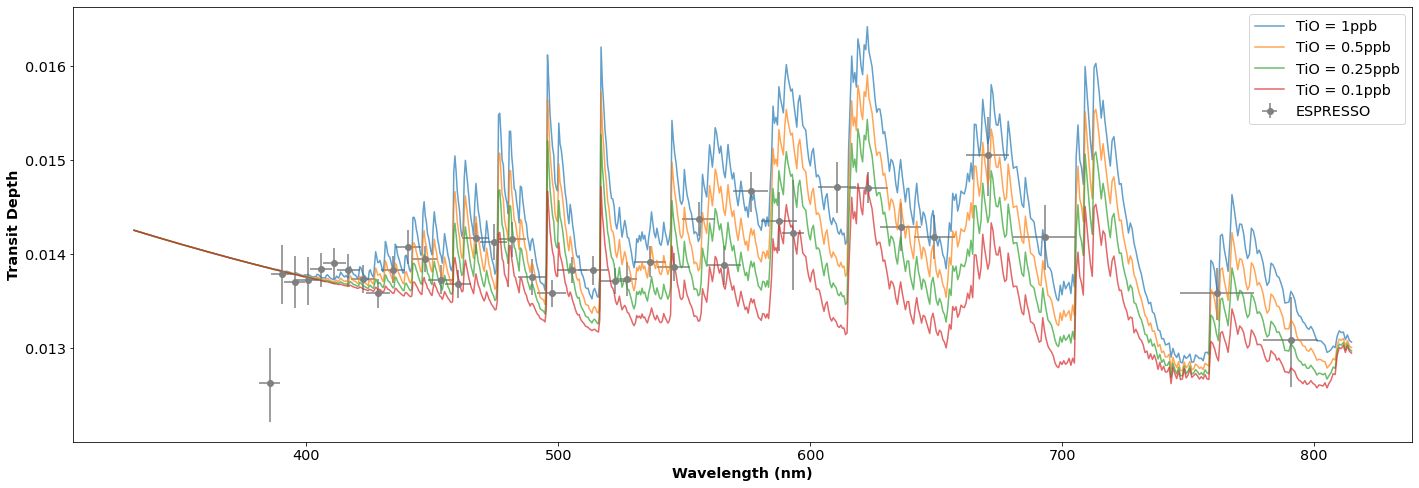

In [85]:
fig, ax = plt.subplots(1,1,figsize=(24,8))

#Plot Espresso Data
ax.errorbar(wavlu_es[2:len(Rp_es)], (Rp_es[2:len(Rp_es)] - 0.0027)**2, 
             yerr=[Rp_eru_sq[2:len(Rp_es)], Rp_erd_sq[2:len(Rp_es)]], 
            xerr=diff[2:len(Rp_es)], marker='o', linestyle='', color='grey', label='ESPRESSO')


ax.plot((nc.c/atm4.freq[100:1000])*1e7, (atm4.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='TiO = 1ppb', alpha=0.7)
ax.plot((nc.c/atm5.freq[100:1000])*1e7, (atm5.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='TiO = 0.5ppb', alpha=0.7)
ax.plot((nc.c/atm6.freq[100:1000])*1e7, (atm6.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='TiO = 0.25ppb', alpha=0.7)
ax.plot((nc.c/atm_1.freq[100:1000])*1e7, (atm_1.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='TiO = 0.1ppb', alpha=0.7)
# ax.plot((nc.c/atm6.freq[100:1000])*1e7, (atm6.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='TiO = 0.01ppb', alpha=0.9)
# ax.plot((nc.c/atm_.freq[100:1000])*1e7, (atm_.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='TiO = 0.001ppb')

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transit Depth")


ax.legend()
plt.savefig("TiOTest3_pRT.jpg", dpi=150)

plt.show()



In [88]:
species

['CO2', 'NH3', 'HCN', 'CH4', 'CO', 'H2O', 'H2']

In [35]:
atm8=pRT(['Na', 'TiO'],[1e-6, 0.5e-9], [22.98, 63.86], prof[:,1][::-1], Tnew, species, mass_fractions, MMW)

del mass_fractions['Na']
del mass_fractions['TiO']

species.remove('Na')
species.remove('TiO')


  Read CIA opacities for H2-H2...
 Done.



In [27]:
atm9=pRT(['Na', 'TiO'],[10e-6, 0.5e-9], [22.98, 63.86], prof[:,1][::-1], Tnew, species, mass_fractions, MMW)

del mass_fractions['Na']
del mass_fractions['TiO']

species.remove('Na')
species.remove('TiO')


  Read CIA opacities for H2-H2...
 Done.



In [28]:
atm10=pRT(['Na', 'TiO'],[1e-6, 1e-9], [22.98, 63.86], prof[:,1][::-1], Tnew, species, mass_fractions, MMW)

del mass_fractions['Na']
del mass_fractions['TiO']

species.remove('Na')
species.remove('TiO')


  Read CIA opacities for H2-H2...
 Done.



In [89]:
atm11=pRT(['Na', 'TiO', 'Li'],[1e-6, 0.5e-9, 1e-6], [22.98, 63.86, 6.94], prof[:,1][::-1], Tnew, species, mass_fractions, MMW)

del mass_fractions['Na']
del mass_fractions['TiO']
del mass_fractions['Li']

species.remove('Na')
species.remove('TiO')
species.remove('Li')



  Read CIA opacities for H2-H2...
 Done.



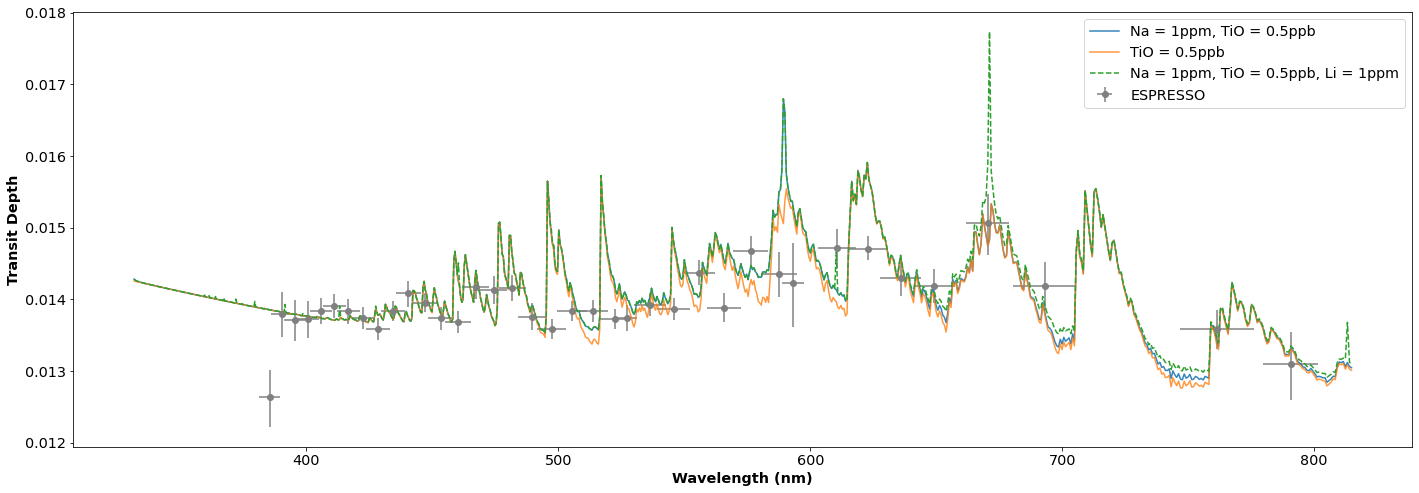

In [107]:
fig, ax = plt.subplots(1,1,figsize=(24,8))

#Plot Espresso Data
ax.errorbar(wavlu_es[2:len(Rp_es)], (Rp_es[2:len(Rp_es)] - 0.0027)**2, 
             yerr=[Rp_eru_sq[2:len(Rp_es)], Rp_erd_sq[2:len(Rp_es)]], 
            xerr=diff[2:len(Rp_es)], marker='o', linestyle='', color='grey', label='ESPRESSO')


ax.plot((nc.c/atm8.freq[100:1000])*1e7, (atm8.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='Na = 1ppm, TiO = 0.5ppb', alpha=0.9)
ax.plot((nc.c/atm5.freq[100:1000])*1e7, (atm5.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='TiO = 0.5ppb', alpha=0.8)
# ax.plot((nc.c/atm9.freq[100:1000])*1e7, (atm9.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='Na = 10ppm, TiO = 0.5ppb', alpha=0.9)
# ax.plot((nc.c/atm10.freq[100:1000])*1e7, (atm10.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='Na = 1ppm, TiO = 1ppb', alpha=0.9)
ax.plot((nc.c/atm11.freq[100:1000])*1e7, (atm11.transm_rad[100:1000]/nc.r_jup_mean)*1e-2,'--',label='Na = 1ppm, TiO = 0.5ppb, Li = 1ppm')


ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transit Depth")


ax.legend()
plt.savefig("NaTiOLiTest3_pRT.jpg", dpi=150)

plt.show()

